In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb
import lightgbm as lgb


In [2]:
df = pd.read_csv("../results/processed_ev_data.csv")
print("Processed data shape:", df.shape)
print(df.head())

# Ensure datetime format
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'])

Processed data shape: (1131, 25)
  User ID Vehicle Model  Battery Capacity (kWh) Charging Station ID  \
0  User_1        BMW i3              108.463007         Station_391   
1  User_2  Hyundai Kona              100.000000         Station_428   
2  User_3    Chevy Bolt               75.000000         Station_181   
3  User_4  Hyundai Kona               50.000000         Station_327   
4  User_5  Hyundai Kona               50.000000         Station_108   

  Charging Station Location  Charging Start Time    Charging End Time  \
0                   Houston  2024-01-01 00:00:00  2024-01-01 00:39:00   
1             San Francisco  2024-01-01 01:00:00  2024-01-01 03:01:00   
2             San Francisco  2024-01-01 02:00:00  2024-01-01 04:48:00   
3                   Houston  2024-01-01 03:00:00  2024-01-01 06:42:00   
4               Los Angeles  2024-01-01 04:00:00  2024-01-01 05:46:00   

   Energy Consumed (kWh)  Charging Duration (hours)  Charging Rate (kW)  ...  \
0              60.712

In [3]:
df['duration_min'] = (df['Charging End Time'] - df['Charging Start Time']).dt.total_seconds() / 60
df['start_hour'] = df['Charging Start Time'].dt.hour
df['day_of_week'] = df['Charging Start Time'].dt.dayofweek  # 0=Mon,6=Sun
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Features & Target
features = ['duration_min', 'Energy Consumed (kWh)', 'start_hour', 'day_of_week', 'is_weekend']
target = 'flexible_kW'

X = df[features]
y = df[target]

# Chronological split (80/20)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (904, 5) Test size: (227, 5)


In [4]:
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

In [6]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 5
[LightGBM] [Info] Start training from score 13.011360
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


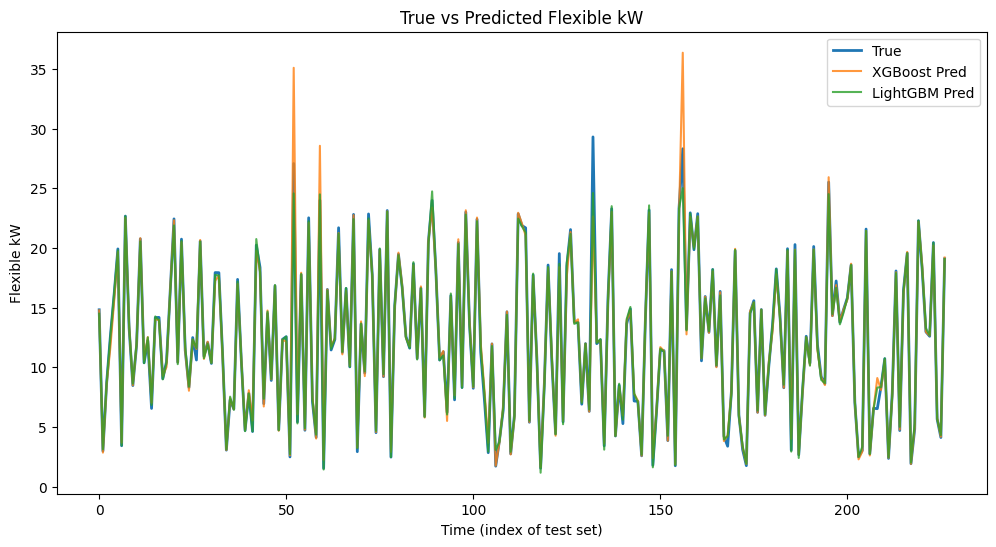

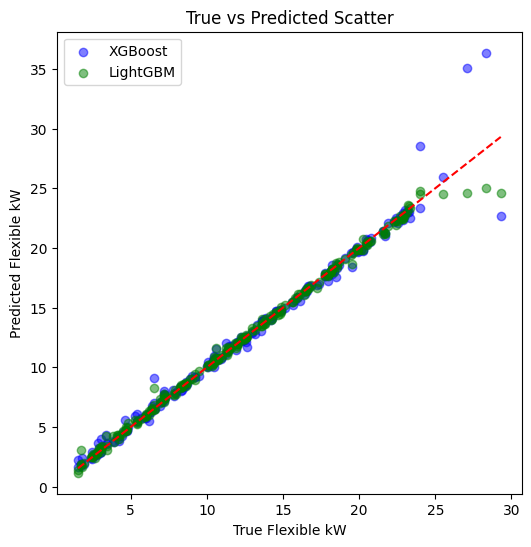

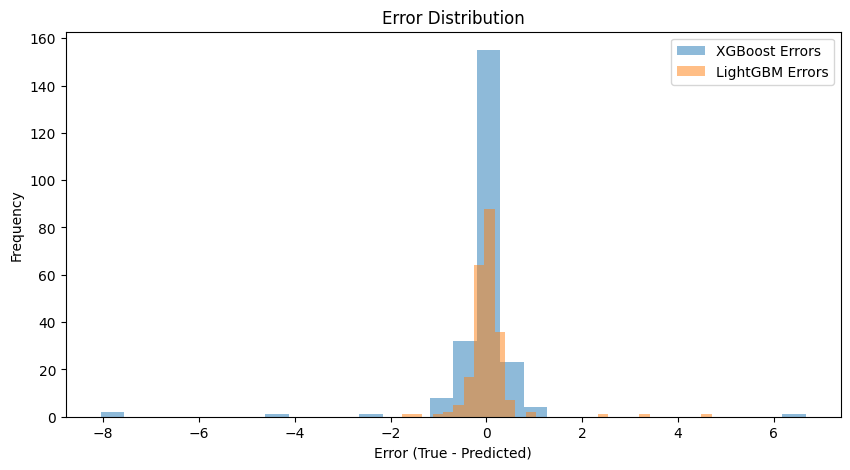

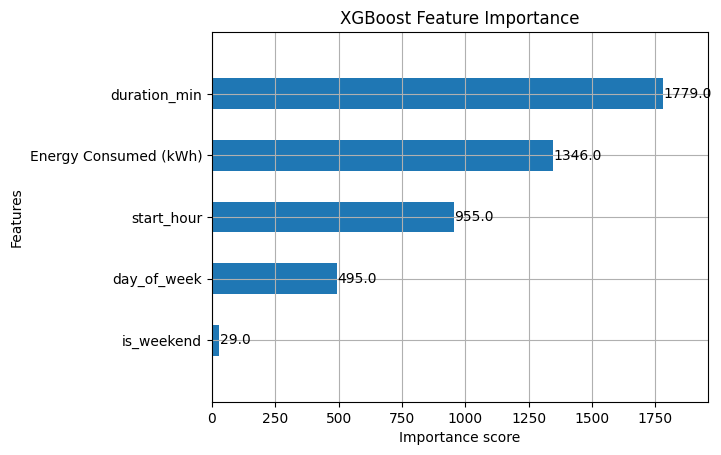

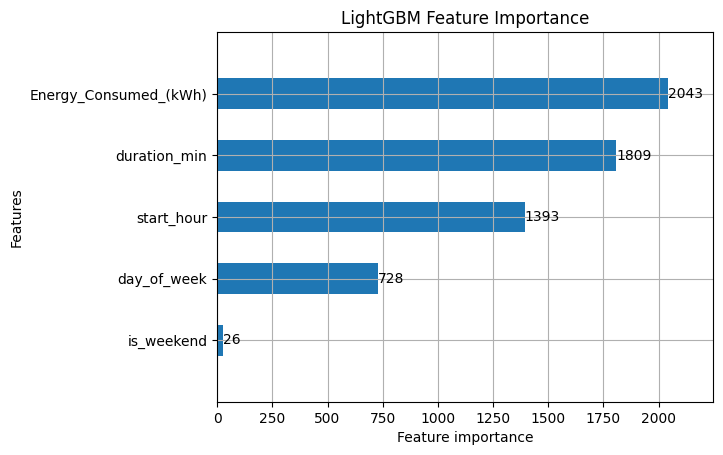

In [10]:
# --------------------------------
# Plot 1: True vs Predicted (Line Plot)
# --------------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="True", linewidth=2)
plt.plot(xgb_preds, label="XGBoost Pred", alpha=0.8)
plt.plot(lgb_preds, label="LightGBM Pred", alpha=0.8)
plt.title("True vs Predicted Flexible kW")
plt.xlabel("Time (index of test set)")
plt.ylabel("Flexible kW")
plt.legend()
plt.show()

# --------------------------------
# Plot 2: Scatter Plot (True vs Predicted)
# --------------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, xgb_preds, alpha=0.5, label="XGBoost", color="blue")
plt.scatter(y_test, lgb_preds, alpha=0.5, label="LightGBM", color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect line
plt.title("True vs Predicted Scatter")
plt.xlabel("True Flexible kW")
plt.ylabel("Predicted Flexible kW")
plt.legend()
plt.show()

# --------------------------------
# Plot 3: Error Distribution
# --------------------------------
xgb_errors = y_test.values - xgb_preds
lgb_errors = y_test.values - lgb_preds

plt.figure(figsize=(10,5))
plt.hist(xgb_errors, bins=30, alpha=0.5, label="XGBoost Errors")
plt.hist(lgb_errors, bins=30, alpha=0.5, label="LightGBM Errors")
plt.title("Error Distribution")
plt.xlabel("Error (True - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# --------------------------------
# Plot 4: Feature Importance
# --------------------------------
xgb.plot_importance(xgb_model, importance_type='weight', height=0.5)
plt.title("XGBoost Feature Importance")
plt.show()

lgb.plot_importance(lgb_model, importance_type='split', height=0.5)
plt.title("LightGBM Feature Importance")
plt.show()


In [7]:
def evaluate_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return rmse, mae

xgb_rmse, xgb_mae = evaluate_model(y_test, xgb_preds, "XGBoost")
lgb_rmse, lgb_mae = evaluate_model(y_test, lgb_preds, "LightGBM")

XGBoost -> RMSE: 0.99, MAE: 0.35
LightGBM -> RMSE: 0.50, MAE: 0.23


In [8]:
results = pd.DataFrame({
    "True": y_test.values,
    "XGBoost_Pred": xgb_preds,
    "LightGBM_Pred": lgb_preds
}, index=y_test.index)

results.to_csv("../results/ml_predictions.csv", index=False)
print("Saved predictions to ../results/ml_predictions.csv")

Saved predictions to ../results/ml_predictions.csv


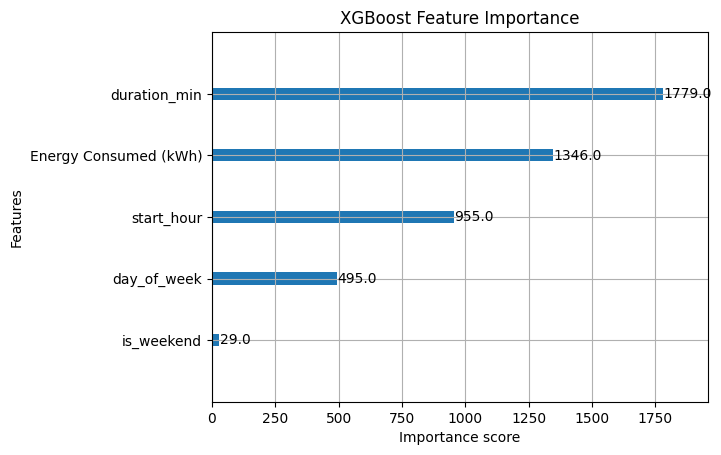

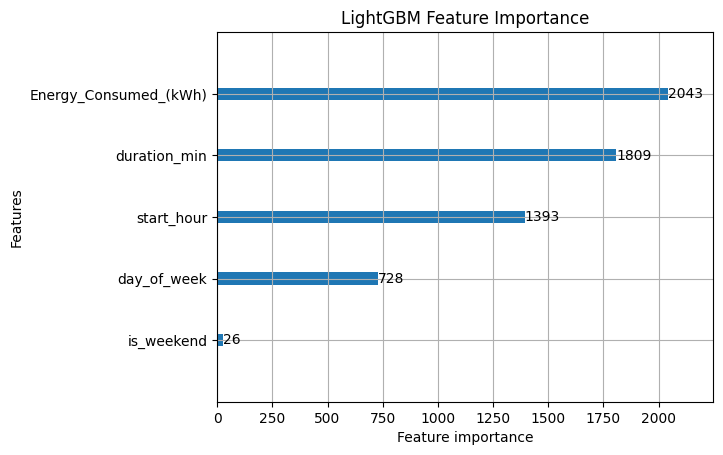

In [9]:
xgb.plot_importance(xgb_model, importance_type='weight')
plt.title("XGBoost Feature Importance")
plt.show()

lgb.plot_importance(lgb_model, importance_type='split')
plt.title("LightGBM Feature Importance")
plt.show()